In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

customers = pd.read_csv('/content/Customers.csv')
#products = pd.read_csv('/mnt/data/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

In [ ]:

customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='inner')

In [ ]:
# Feature Engineering
# Calculate total spend, number of transactions, and average transaction value for each customer
customer_features = customer_transactions.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    num_transactions=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean')
).reset_index()

In [ ]:

customer_features = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

In [ ]:
# Encode region as numerical data
customer_features['Region'] = customer_features['Region'].astype('category').cat.codes

# Prepare data for clustering
features = customer_features[['total_spent', 'num_transactions', 'avg_transaction_value', 'Region']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
# Perform clustering
cluster_results = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    cluster_results[n_clusters] = {
        'model': kmeans,
        'labels': labels,
        'db_index': db_index
    }

In [ ]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25%)
    Q3 = df[column].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1                   # Interquartile range
    lower_bound = Q1 - 1.5 * IQR    # Lower bound
    upper_bound = Q3 + 1.5 * IQR    # Upper bound
    # Filter the data to include only rows within bounds
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from 'Total_Spent' and 'Quantity'
cluster_data_no_outliers = remove_outliers_iqr(cluster_data, 'Total_Spent')
cluster_data_no_outliers = remove_outliers_iqr(cluster_data_no_outliers, 'Quantity')

# Display the number of rows before and after removing outliers
print(f"Original rows: {len(cluster_data)}")
print(f"Rows after outlier removal: {len(cluster_data_no_outliers)}")



Original rows: 42
Rows after outlier removal: 42


In [ ]:
# Add cluster labels to the data
customer_features['Cluster'] = best_labels

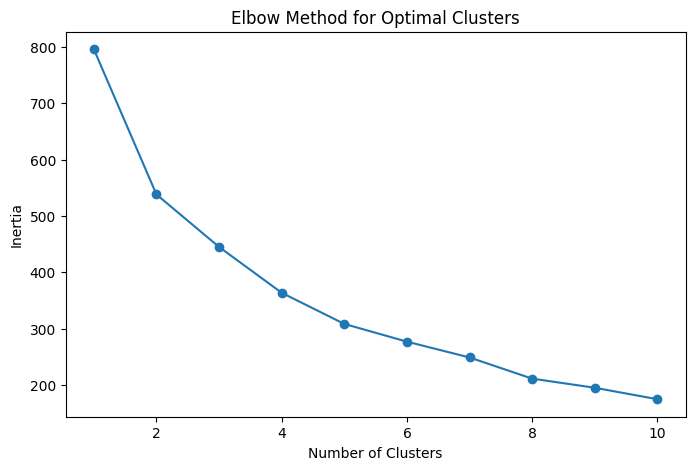

In [ ]:
# Elbow Method to determine the optimal number of clusters
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()



In [ ]:
# Perform clustering
cluster_results = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    cluster_results[n_clusters] = {
        'model': kmeans,
        'labels': labels,
        'db_index': db_index
    }

In [ ]:
# Find the best number of clusters (lowest DB Index)
best_n_clusters = min(cluster_results, key=lambda x: cluster_results[x]['db_index'])
best_model = cluster_results[best_n_clusters]['model']
best_labels = cluster_results[best_n_clusters]['labels']
best_db_index = cluster_results[best_n_clusters]['db_index']

print(f"Best number of clusters: {best_n_clusters}")
print(f"Davies-Bouldin Index: {best_db_index}")


Best number of clusters: 10
Davies-Bouldin Index: 0.9957526812503525


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(scaled_features, optimal_labels)

print(f"Silhouette Score for Optimal Clusters ({optimal_k}): {silhouette_avg:.4f}")
#not a good score

Silhouette Score for Optimal Clusters (4): 0.1087


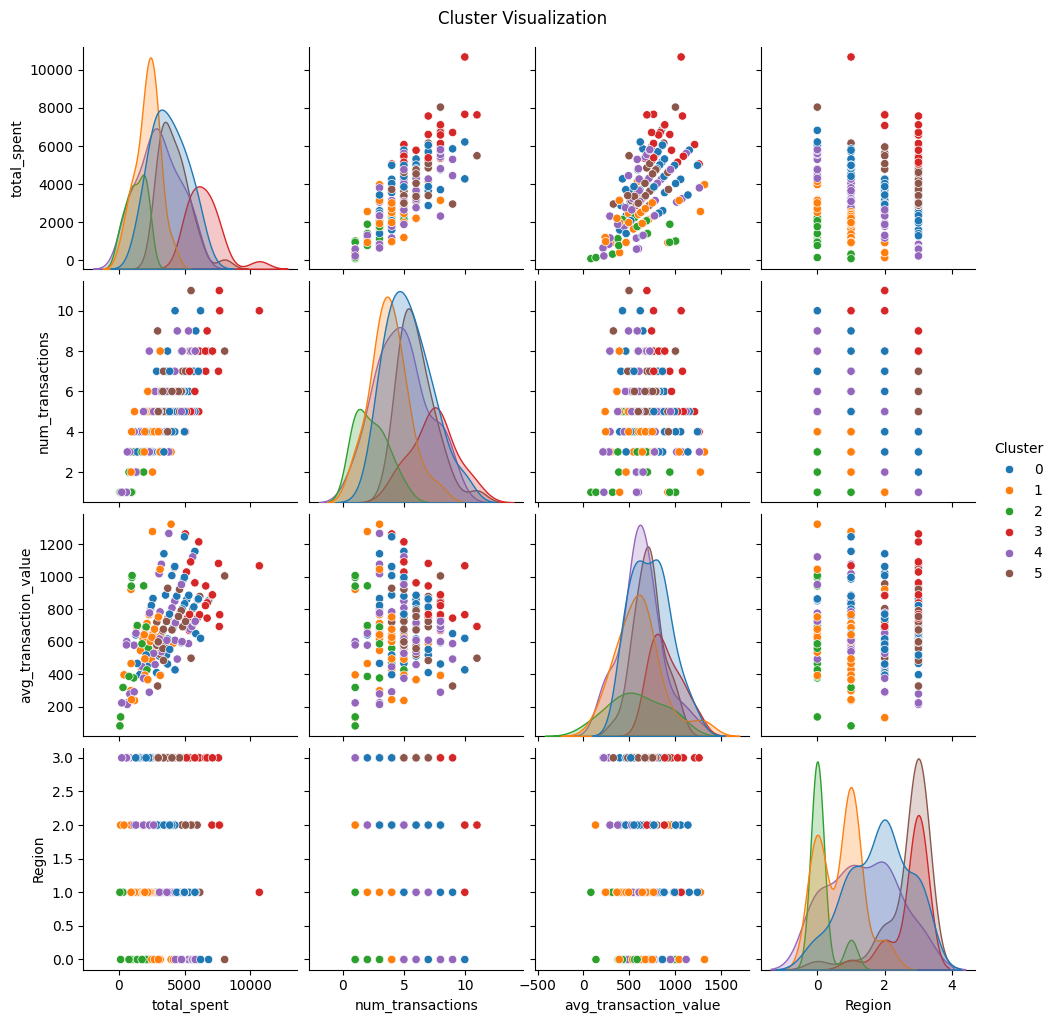

In [ ]:
# Visualization
sns.pairplot(customer_features, hue='Cluster', diag_kind='kde', palette='tab10')
plt.suptitle('Cluster Visualization', y=1.02)
plt.show()

Best number of clusters: 10
Davies-Bouldin Index: 0.9957526812503525


Text(0.5, 0, 'Average Transaction Value')

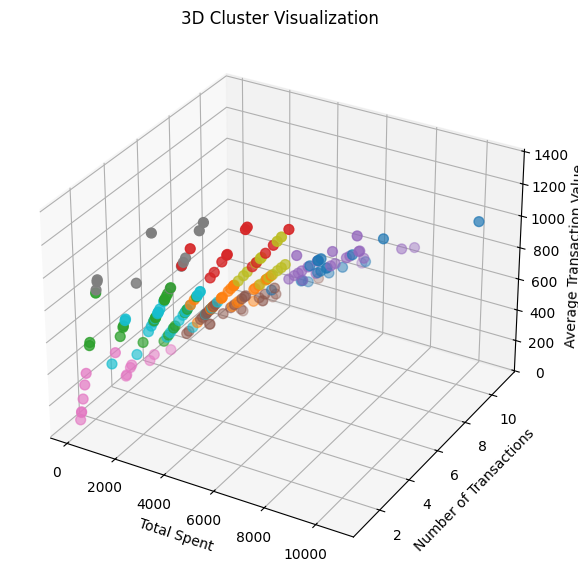

In [ ]:
# Find the best number of clusters (lowest DB Index)
best_n_clusters = min(cluster_results, key=lambda x: cluster_results[x]['db_index'])
best_model = cluster_results[best_n_clusters]['model']
best_labels = cluster_results[best_n_clusters]['labels']
best_db_index = cluster_results[best_n_clusters]['db_index']

print(f"Best number of clusters: {best_n_clusters}")
print(f"Davies-Bouldin Index: {best_db_index}")

# Add cluster labels to the data
customer_features['Cluster'] = best_labels

# 3D Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract features for visualization
x = customer_features['total_spent']
y = customer_features['num_transactions']
z = customer_features['avg_transaction_value']

# Scatter plot
scatter = ax.scatter(x, y, z, c=customer_features['Cluster'], cmap='tab10', s=50)
ax.set_title('3D Cluster Visualization')
ax.set_xlabel('Total Spent')
ax.set_ylabel('Number of Transactions')
ax.set_zlabel('Average Transaction Value')



## Decision Tree

In [ ]:
# Decision Tree for Cluster Interpretation
X = customer_features[['total_spent', 'num_transactions', 'avg_transaction_value', 'Region']]
y = customer_features['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)



DecisionTreeClassifier(random_state=42)

In [ ]:
# Feature importance visualization
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': decision_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)



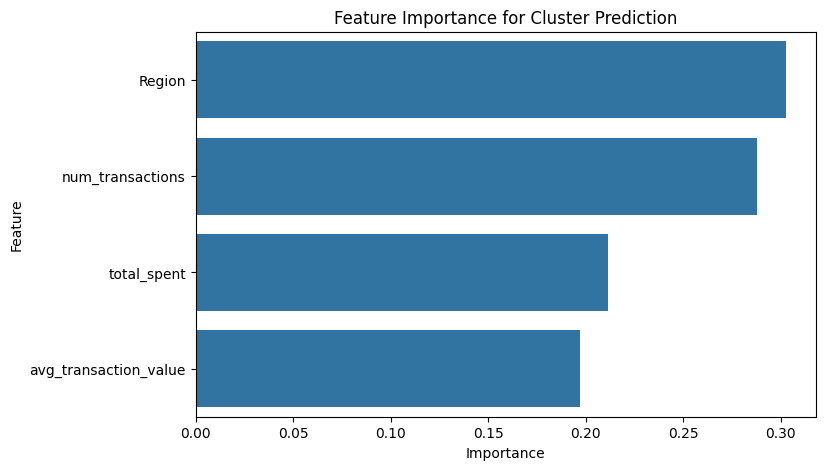

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance for Cluster Prediction')
plt.show()



In [ ]:

customer_features.to_csv('Customer_Segmentation_Results.csv', index=False)


## Clustering with K Means and PCA

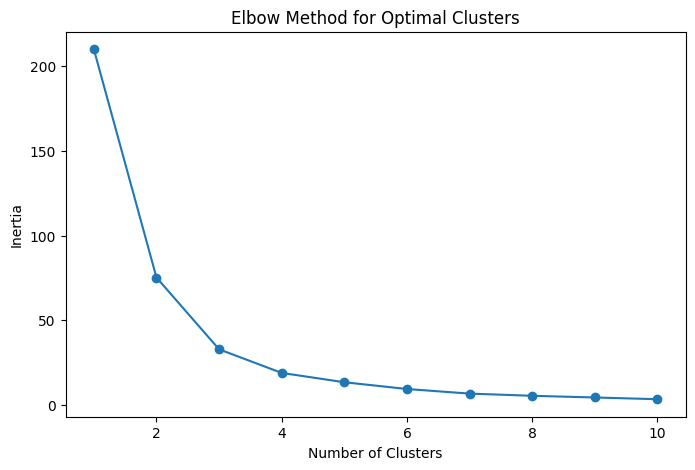

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


customers = pd.read_csv('/content/Customers.csv')
#products = pd.read_csv('/mnt/data/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')


customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='inner')

# Feature Engineering
# Calculate total spend, number of transactions, and average transaction value for each customer
customer_features = customer_transactions.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    num_transactions=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean')
).reset_index()

# Merge features with region data
customer_features = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Encode region as numerical data
customer_features['Region'] = customer_features['Region'].astype('category').cat.codes

# Prepare data for clustering
features = customer_features[['total_spent', 'Region']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# PCA for dimensionality reduction
pca = PCA(n_components=1)
pca_features = pca.fit_transform(scaled_features)

# Elbow Method to determine the optimal number of clusters
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Perform clustering with KMeans
cluster_results = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pca_features)
    db_index = davies_bouldin_score(pca_features, labels)
    silhouette = silhouette_score(pca_features, labels)
    cluster_results[n_clusters] = {
        'model': kmeans,
        'labels': labels,
        'db_index': db_index,
        'silhouette': silhouette
    }



Best number of clusters: 6
Davies-Bouldin Index: 0.5403931461360615
Silhouette Score: 0.5133011633089261


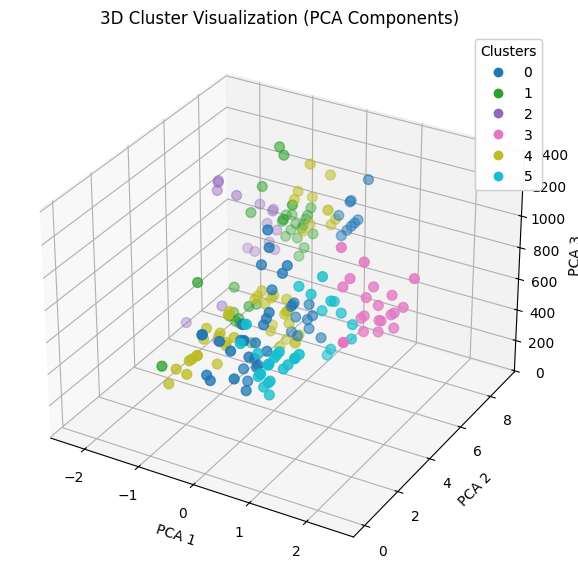

In [ ]:
# Find the best number of clusters (lowest DB Index)
#best_n_clusters = min(cluster_results, key=lambda x: cluster_results[x]['db_index'])
best_n_clusters = min(cluster_results, key=lambda x: cluster_results[x]['silhouette'])
best_model = cluster_results[best_n_clusters]['model']
best_labels = cluster_results[best_n_clusters]['labels']
best_db_index = cluster_results[best_n_clusters]['db_index']
best_silhouette = cluster_results[best_n_clusters]['silhouette']

print(f"Best number of clusters: {best_n_clusters}")
print(f"Davies-Bouldin Index: {best_db_index}")
print(f"Silhouette Score: {best_silhouette}")

# Add cluster labels to the data
customer_features['Cluster'] = best_labels

# 3D Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract PCA components for visualization
x = pca_features[:, 0]


# Scatter plot
scatter = ax.scatter(x, y, z, c=customer_features['Cluster'], cmap='tab10', s=50)
ax.set_title('3D Cluster Visualization (PCA Components)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()




In [ ]:
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Merge customer and transaction data
merged_df = pd.merge(customers_df, transactions_df, on="CustomerID")

# Feature engineering (example)
merged_df["Total_Spent"] = merged_df["Quantity"] * merged_df["Price"]
customer_agg = merged_df.groupby("CustomerID").agg({
    "Total_Spent": "sum",
    "Quantity": "sum"
}).reset_index()

# Merge aggregated transaction data with customer profile
final_df = pd.merge(customers_df, customer_agg, on="CustomerID")

# Select relevant features
features = [ "Total_Spent", "Quantity"]
X = final_df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



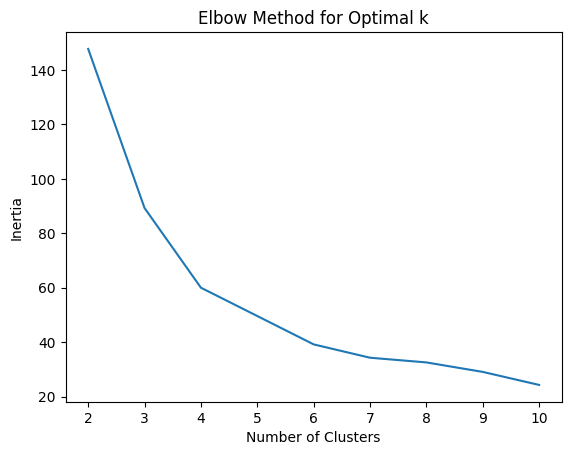

In [ ]:
# --- Determine Optimal Number of Clusters ---

inertia = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()



In [ ]:
# --- K-Means Clustering ---

# optimal number of clusters
optimal_k = 4

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

# Add cluster labels to the dataframe
final_df["Cluster"] = kmeans.labels_



In [ ]:
# --- Evaluation Metrics ---

# Calculate DB Index
db_index = davies_bouldin_score(X_scaled, kmeans.labels_)
print("DB Index:", db_index)



# Assuming X_scaled and kmeans are already defined
sil_score = silhouette_score(X_scaled, kmeans.labels_)
print("Silhouette Score:", sil_score)

#much better than before

DB Index: 0.72127971818163
Silhouette Score: 0.4497501059000638


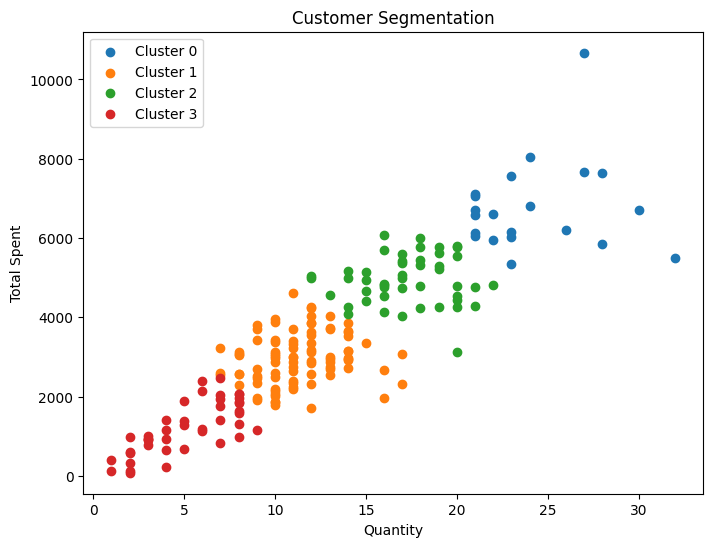

In [ ]:
# --- Visualization ---

plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    cluster_data = final_df[final_df["Cluster"] == i]
    plt.scatter(cluster_data["Quantity"], cluster_data["Total_Spent"], label=f"Cluster {i}")

plt.xlabel("Quantity")
plt.ylabel("Total Spent")
plt.title("Customer Segmentation")
plt.legend()
plt.show()

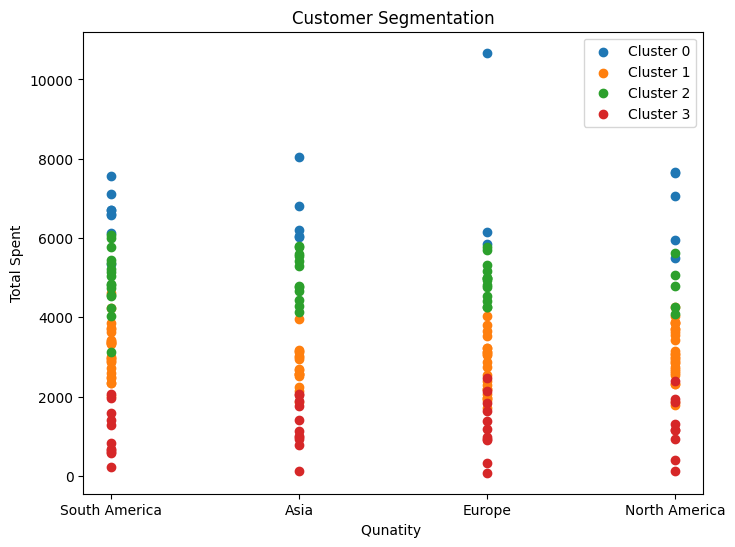

In [ ]:
# --- Visualization ---

plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    cluster_data = final_df[final_df["Cluster"] == i]
    plt.scatter(cluster_data["Region"], cluster_data["Total_Spent"], label=f"Cluster {i}")

plt.xlabel("Qunatity ")
plt.ylabel("Total Spent")
plt.title("Customer Segmentation")
plt.legend()
plt.show()

## Clustering with K-Means, PCA and RMF

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

#  Merge the data based on CustomerID
data = pd.merge(customers, transactions, on='CustomerID')


In [ ]:
#  Create RFM Features (Recency, Frequency, Monetary)
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
latest_date = transactions['TransactionDate'].max()

# Group by customer and calculate RFM metrics
rfm = transactions.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda x: (latest_date - x.max()).days),
    Frequency=('TransactionID', 'count'),
    Monetary=('TotalValue', 'sum')
).reset_index()

# Merge RFM features with customer profile data
data = pd.merge(customers, rfm, on='CustomerID', how='left')




In [ ]:
#  Drop non-numeric columns
data = data.drop(['SignupDate', 'CustomerID', 'CustomerName'], axis=1)

# One-hot encode categorical columns like 'Region'
data_encoded = pd.get_dummies(data, columns=['Region'], drop_first=True)



In [ ]:
data

,Region,Recency,Frequency,Monetary
0,South America,55.0,5.0,3354.52
1,Asia,25.0,4.0,1862.74
2,South America,125.0,4.0,2725.38
3,South America,4.0,8.0,5354.88
4,Asia,54.0,3.0,2034.24
...,...,...,...,...
195,Europe,13.0,4.0,4982.88
196,Europe,0.0,3.0,1928.65
197,Europe,84.0,2.0,931.83
198,Europe,63.0,4.0,1979.28


In [ ]:
#  Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_encoded_imputed = pd.DataFrame(imputer.fit_transform(data_encoded), columns=data_encoded.columns)



In [ ]:
#  Standardize the numerical features
scaler = MinMaxScaler()  # Trying MinMaxScaler
scaled_data = scaler.fit_transform(data_encoded_imputed)



In [ ]:
# K-Means Clustering with different n_clusters
n_clusters_range = range(2, 11)  # Test clusters from 2 to 10
best_score = -1
best_n_clusters = 2
best_kmeans = None

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        best_kmeans = kmeans

# Best K-Means Clustering
print(f"Best number of clusters: {best_n_clusters} with Silhouette Score: {best_score}")



Best number of clusters: 4 with Silhouette Score: 0.6263578055834661


In [ ]:
# Visualize the clusters in 2D using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
data_encoded_imputed['PCA1'] = pca_components[:, 0]
data_encoded_imputed['PCA2'] = pca_components[:, 1]
data_encoded_imputed['Cluster'] = best_kmeans.predict(scaled_data)



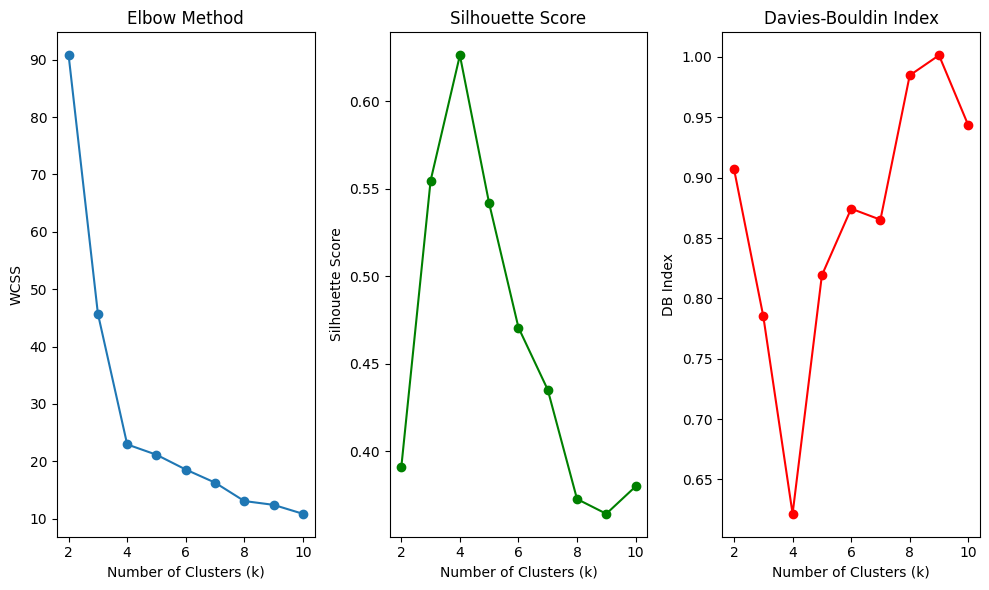

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


k_range = range(2, 11)

# Initialize lists to store the results for each k
wcss = []  # For Elbow Method (Within-Cluster Sum of Squares)
silhouette_scores = []  # For Silhouette Score
db_scores = []  # For Davies-Bouldin Index

# Loop through each k to calculate clustering metrics
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    # WCSS for Elbow Method
    wcss.append(kmeans.inertia_)

    # Silhouette Score
    sil_score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(sil_score)

    # DB Index
    db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
    db_scores.append(db_index)

# Step 2: Plot the Elbow Method (WCSS)
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.plot(k_range, wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')

# Step 3: Plot Silhouette Scores
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# Step 4: Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_range, db_scores, marker='o', color='red')
plt.title("Davies-Bouldin Index")
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')

# Display all plots
plt.tight_layout()
plt.show()


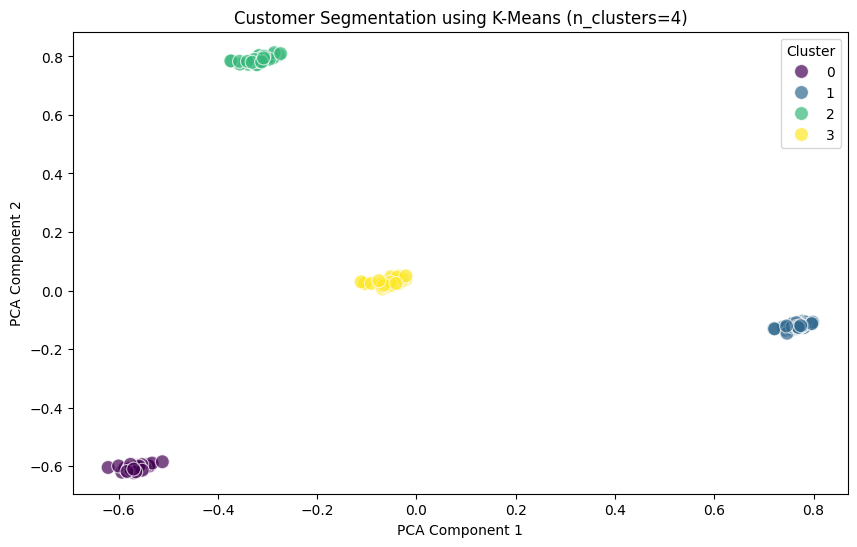

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data_encoded_imputed, palette='viridis', s=100, alpha=0.7)
plt.title(f'Customer Segmentation using K-Means (n_clusters={best_n_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:

# Evaluate clustering
sil_score = silhouette_score(scaled_data, data_encoded_imputed['Cluster'])
db_index = davies_bouldin_score(scaled_data, data_encoded_imputed['Cluster'])

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
# best score as of now

Silhouette Score: 0.6263578055834661
Davies-Bouldin Index: 0.6215427171683032
